In [32]:
#Import modules
import pandas as pd
import matplotlib
from matplotlib import pyplot as plot
from datetime import datetime, date, timedelta
from matplotlib.pyplot import figure          

In [33]:
url = 'https://raw.githubusercontent.com/umaimehm/Intro_to_AI/master/assignment1/Ruter_data.csv'

In [34]:
df = pd.read_csv(url, sep=';')

In [35]:
#Converts str to time, replace 24 with 00, 25 with 01
#If changeDate is set to True, the date change whit the change of time (use it for first run only)
def strToTime(rowName, changeDate=False):
    x=rowName                               #Name of the row evaluated
    for i, row in df.iterrows():            #df.iterrows() is the buildt in iter from pandas, haven't read documentation, too tierd right now
        changed=False                       #But it works
        if row[x][:2]=="24":                #Checks if %H is 24   
            df.at[i,x] = "00:"+row[x][3:]   #And change to 00
            changed=True                    #Just a flag that time has changed, so the date change as well
        elif row[x][:2]=="25":              #If changeDate is active
            df.at[i,x] = "01:"+row[x][3:]
            changed=True
        elif row[x][:2]=="26":
            df.at[i,x] = "02:"+row[x][3:]
            changed=True
        elif row[x][:2]==":":
            df.at[i,x] = "00:00:01"
            changed=True
        else:
            pass
        if changed and changeDate:          #Adds one day to date where time has changed above
            df.at[i,"Dato"]=row["Dato"] +  timedelta(days=1)
    df[x] = pd.to_datetime(df[x],format= '%H:%M:%S' ).dt.time  #Change from string to date time object
    print("done with" + x)                                     #The loop take some time, so just provideing som feedback

In [36]:
df['Dato'] = pd.to_datetime(df['Dato'])

In [37]:
df['Dato'] = pd.to_datetime(df['Dato'])                #Convert date to a datetime object
strToTime('Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra', changeDate = True)  #Convert time to a datetime object, change date when time is over 24:00:00
strToTime('Tidspunkt_Faktisk_Avgang_Holdeplass_Fra')         #Change time to datetime, no need for future date change
strToTime('Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra')
strToTime('Tidspunkt_Planlagt_Avgang_Holdeplass_Fra')


done withTidspunkt_Faktisk_Ankomst_Holdeplass_Fra
done withTidspunkt_Faktisk_Avgang_Holdeplass_Fra
done withTidspunkt_Planlagt_Ankomst_Holdeplass_Fra
done withTidspunkt_Planlagt_Avgang_Holdeplass_Fra


In [38]:
df.head(13)


,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,2020-10-08,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,2020-08-15,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,2020-03-08,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,2020-07-27,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,2020-08-27,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10
5,3110-2020-08-01T16:16:00+02:00,2020-01-08,Oslo,Nordøst,Bjerke,Veitvet (mot Kalbakken),Rødtvet (mot Kalbakken),Lokal,Oslo,31,0,17:22:56,17:23:23,17:16:00,17:16:00,151,8
6,15010-2020-07-28T13:09:00+02:00,2020-07-28,Viken,Vest,Bærum,Nedre Toppenhaug,Øvre Toppenhaug,Lokal,Viken,150,0,13:19:00,13:19:05,13:17:00,13:17:00,112,1
7,15003-2020-07-27T06:18:00+02:00,2020-07-27,Oslo,Indre By,St.Hanshaugen,Hammersborggata (ved Storgata retning vest),St. Olavs plass (mot Frederiks gate),Lokal,Viken,150,1,06:20:24,06:20:29,06:20:00,06:20:00,112,-1
8,21002-2020-08-16T14:33:00+02:00,2020-08-16,Viken,Vest,Bærum,Stein gård,Knabberudveien,Lokal,Viken,150,1,15:10:12,15:10:34,15:09:00,15:09:00,112,2
9,15002-2020-08-13T18:09:00+02:00,2020-08-13,Viken,Vest,Bærum,Bekkestua bussterminal (Plattform C),Stabekk skole,Lokal,Viken,150,0,18:37:41,18:38:19,18:29:00,18:29:00,112,4


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   TurId                                      6000 non-null   object        
 1   Dato                                       6000 non-null   datetime64[ns]
 2   Fylke                                      6000 non-null   object        
 3   Område                                     6000 non-null   object        
 4   Kommune                                    6000 non-null   object        
 5   Holdeplass_Fra                             6000 non-null   object        
 6   Holdeplass_Til                             6000 non-null   object        
 7   Linjetype                                  6000 non-null   object        
 8   Linjefylke                                 6000 non-null   object        
 9   Linjenavn          

In [51]:
df['Time_At_Stop'] = df.apply(lambda row: datetime.combine(datetime(1,1,1,0,0,0), row.Tidspunkt_Faktisk_Avgang_Holdeplass_Fra) - datetime.combine(datetime(1,1,1,0,0,0), row.Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra), axis = 1)
# Substract Faktisk Avgang with Faktisk Ankomst to find stop time. (Datetime(1,1,1,0,0,0) is a dummy placeholder to be able to substract.)

In [52]:
df.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,StopTime_Fra,Ukedag,Forsinkelse,Time_At_Stop
3366,30017-2020-06-01T19:25:00+02:00,2020-01-06,Viken,Nordøst,Lillestrøm,Frydenlundsgata,Sagdalen skole,Lokal,Viken,110,...,20:11:18,20:11:25,20:09:00,20:09:00,106,1,0 days 00:00:07,Monday,0 days 00:02:18,0 days 00:00:07
2544,38001-2020-06-01T15:02:00+02:00,2020-01-06,Oslo,Nordøst,Grorud,Bånkallstubben (mot Grorud),Rommi,Lokal,Viken,380,...,15:31:10,15:31:44,15:28:00,15:28:00,115,7,0 days 00:00:34,Monday,0 days 00:03:10,0 days 00:00:34
984,12011-2020-06-01T14:15:00+02:00,2020-01-06,Viken,Nordøst,Lørenskog,Glenneveien,Rasta skole,Lokal,Viken,310,...,14:47:42,14:47:47,14:44:00,14:44:00,72,2,0 days 00:00:05,Monday,0 days 00:03:42,0 days 00:00:05
4358,42003-2020-06-01T13:32:00+02:00,2020-01-06,Viken,Nordøst,Nannestad,Herstukrysset,Kopperud,Lokal,Viken,420,...,14:32:15,14:32:27,14:32:00,14:32:00,106,-14,0 days 00:00:12,Monday,0 days 00:00:15,0 days 00:00:12
5280,39009-2020-06-01T19:23:00+02:00,2020-01-06,Viken,Nordøst,Nittedal,Kjul,Måsan,Lokal,Viken,385,...,20:04:11,20:04:17,20:03:00,20:03:00,115,0,0 days 00:00:06,Monday,0 days 00:01:11,0 days 00:00:06


In [42]:
df['Ukedag'] = df['Dato'].dt.day_name()

In [43]:
df['Forsinkelse'] = df.apply(lambda row: datetime.combine(datetime(1,1,1,0,0,0), row.Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra) - datetime.combine(datetime(1,1,1,0,0,0), row.Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra), axis = 1)
# Substract Faktisk Avgang with Faktisk Ankomst to find stop time. (Datetime(1,1,1,0,0,0) is a dummy placeholder to be able to substract.)

Text(0.5, 1.0, 'Stop Time Based on day of the week')

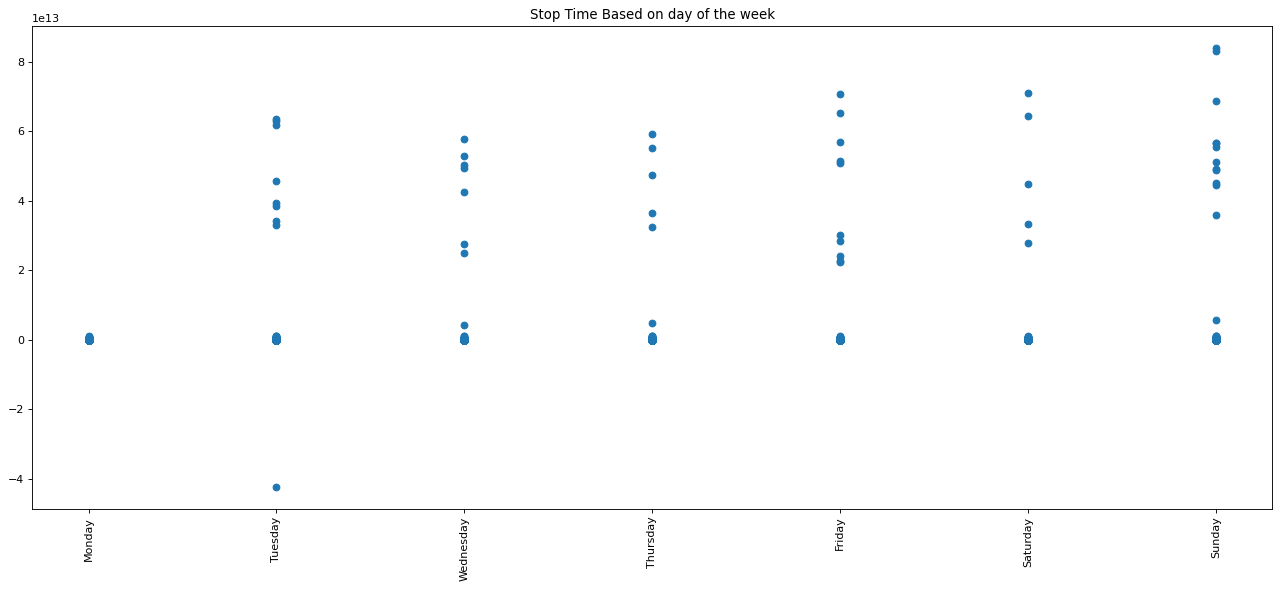

In [54]:
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')  #Set the size of plotdf = df.sort_values('Dato', ascending=True)                             #Sorting dates (dont know if this is needed)
plot.plot(df['Ukedag'], df['Time_At_Stop'], 'o')                      #Plotting Stoptime with date, 'o' - gives scatter plot
plot.xticks(rotation='vertical')
plot.title('Stop Time Based on day of the week')

In [46]:
df["StopTime_Fra"].mean()

Timedelta('0 days 00:06:41.359333333')

Text(0.5, 1.0, 'Forsinkelse')

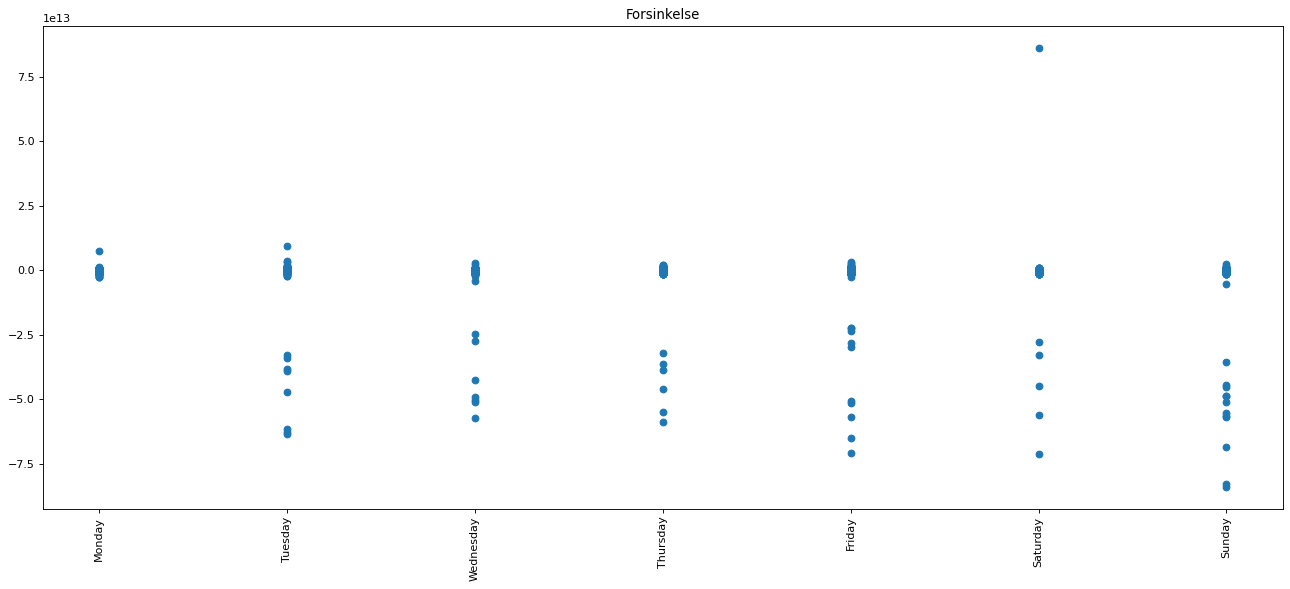

In [50]:
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')  #Set the size of plotdf = df.sort_values('Dato', ascending=True)                             #Sorting dates (dont know if this is needed)
plot.plot(df['Ukedag'], df['Forsinkelse'], 'o')                      #Plotting Stoptime with date, 'o' - gives scatter plot
plot.xticks(rotation='vertical')
plot.title('Forsinkelse')

In [48]:
df = df.sort_values('Dato', ascending=True)

Text(0, 0.5, 'Count')

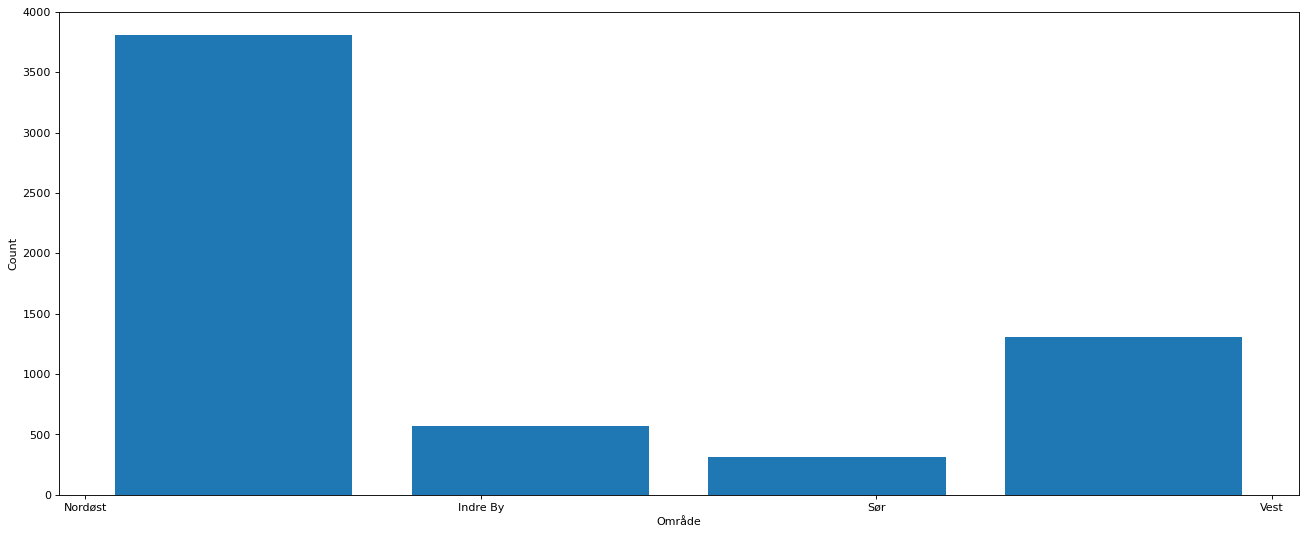

In [58]:
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')  #Set the size of plot
plot.hist(df.Område, bins=4, rwidth=0.8)
plot.xlabel('Område')
plot.ylabel('Count')